In [25]:
import joblib
import rasterio
import rasterio.plot

import data
import datasets
import satellite

In [26]:
AGGREGATE_LAYER_COUNT = 3
AGGREGATE_LAYER_START = 1
GRID_SEARCH_PIXEL_STEP_X = 16
GRID_SEARCH_PIXEL_STEP_Y = 16
MEASUREMENT_DISAMBIGUATION_MODE = lambda series: series.max([TARGET_COLUMN])
PIXEL_LAYER_COUNT = 3
PIXEL_LAYER_START = 0
POSITIVE_THRESHOLD = 100
SEED = 84
TARGET_COLUMN = "SN"

In [27]:
satellite_image = datasets.satellite_image()

In [28]:
satellite_data_frame = datasets.geochemical_satellite_analysis(satellite_image, TARGET_COLUMN, POSITIVE_THRESHOLD)
satellite.create_features(satellite_data_frame, satellite_image, PIXEL_LAYER_START, PIXEL_LAYER_COUNT, AGGREGATE_LAYER_START, AGGREGATE_LAYER_COUNT)

In [29]:
index_data_frame = satellite.create_summary_data_frame(satellite_data_frame, satellite_image, TARGET_COLUMN, MEASUREMENT_DISAMBIGUATION_MODE, PIXEL_LAYER_START, PIXEL_LAYER_COUNT, AGGREGATE_LAYER_START, AGGREGATE_LAYER_COUNT)
x_labels = index_data_frame.x_labels()
y_labels = index_data_frame.y_labels()

In [30]:
import sklearn.ensemble

best_seed = None
best_score = None

x_train, y_train, x_test, y_test = data.split_train_test(index_data_frame, x_labels, y_labels, seed=SEED)

histogram = sklearn.ensemble.HistGradientBoostingRegressor(loss="squared_error", validation_fraction=0.2, min_samples_leaf=5, random_state=SEED).fit(x_train, y_train)

print("Training Score", histogram.score(x_train, y_train))
print("Test Score", histogram.score(x_test, y_test))

# import joblib
# joblib.dump(histogram, f"Models/Satellite{TARGET_COLUMN}Histogram.joblib")

# import skl2onnx 
# import skl2onnx.common.data_types
# initial_type = [("input", skl2onnx.common.data_types.FloatTensorType([None, x_train.shape[1]]))]
# with open(f"Models/Satellite{TARGET_COLUMN}Histogram.onnx", "wb") as file:
#     file.write(skl2onnx.convert_sklearn(histogram, initial_types=initial_type).SerializeToString())

Training Score 0.9628967569714186
Test Score 0.062637827975497


In [31]:
satellite_data_frame[f"{TARGET_COLUMN}_PREDICTED"] = histogram.predict(satellite_data_frame[x_labels])
satellite_data_frame.to_csv(f"Output/{TARGET_COLUMN} Histogram Satellite Predictions.csv", sep=",", index=False)

c:\Users\ongan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but HistGradientBoostingRegressor was fitted without feature names
  warnings.warn(


In [32]:
grid_search_data_frame = satellite.create_grid_search_data_frame(satellite_image, GRID_SEARCH_PIXEL_STEP_X, GRID_SEARCH_PIXEL_STEP_Y, PIXEL_LAYER_START, PIXEL_LAYER_COUNT, AGGREGATE_LAYER_START, AGGREGATE_LAYER_COUNT)

In [33]:
grid_search_data_frame[TARGET_COLUMN] = histogram.predict(grid_search_data_frame[x_labels])
grid_search_data_frame[f"{TARGET_COLUMN}_THRESHOLD"] = grid_search_data_frame[TARGET_COLUMN].ge(POSITIVE_THRESHOLD)
grid_search_data_frame.to_csv(f"Output/{TARGET_COLUMN} Histogram Grid Search.csv", sep=",", index=False)

c:\Users\ongan\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but HistGradientBoostingRegressor was fitted without feature names
  warnings.warn(


In [34]:
joblib.dump(grid_search_data_frame, f"Output/{TARGET_COLUMN} Grid Search Data Frame.joblib")

['Output/SN Grid Search Data Frame.joblib']

In [35]:
abridged_grid_search_data_frame = grid_search_data_frame[["EAST", "NORTH", TARGET_COLUMN]]
abridged_grid_search_data_frame.to_csv(f"Output/Abridged {TARGET_COLUMN} Histogram Grid Search.csv", sep=",", index=False)

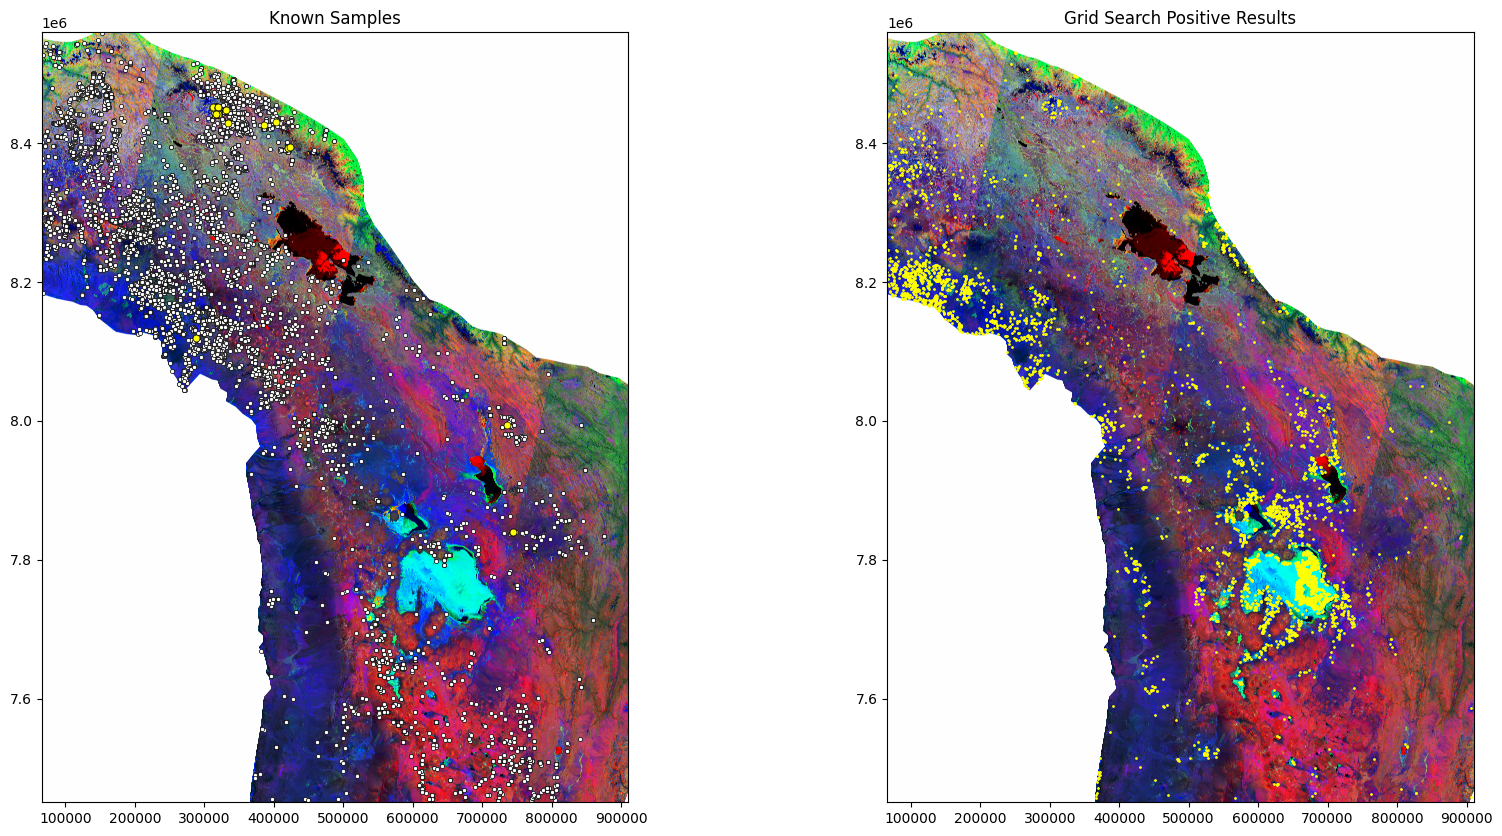

In [36]:
import matplotlib.pyplot

figure, axes = matplotlib.pyplot.subplots(nrows=1, ncols=2, figsize=(20, 10))
satellite_data_frame[satellite_data_frame[f"{TARGET_COLUMN}_THRESHOLD"] == False].plot(ax=axes[0], legend=True, color="white", markersize=9, linewidth=0.5, edgecolors="black")
satellite_data_frame[satellite_data_frame[f"{TARGET_COLUMN}_THRESHOLD"]].plot(ax=axes[0], legend=True, color="yellow", markersize=25, linewidth=0.5, edgecolors="black")
axes[0].set_title(f"Known Samples")
grid_search_data_frame[grid_search_data_frame[f"{TARGET_COLUMN}_THRESHOLD"]].plot(ax=axes[1], legend=True, color="yellow", markersize=1)
axes[1].set_title(f"Grid Search Positive Results")
rasterio.plot.show(satellite_image, ax=axes[0])
rasterio.plot.show(satellite_image, ax=axes[1])
matplotlib.pyplot.savefig(f"Output/{TARGET_COLUMN} Figure.png")